In [5]:
import numpy as np
from scipy.stats import dirichlet
from math import comb
import matplotlib.pyplot as plt
import random
import os
import scipy as sp 
import seaborn as sns

# loggamma: log of the Gamma function defined for x>0.
# binom: 
from scipy.special import binom, loggamma

# from matplotlib import rcParams

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.font_manager

from classes import moment_analytic

os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
rcParams['font.family'] = 'serif'
rcParams['mathtext.default'] = 'regular'
rcParams['figure.figsize'] = (20,15)
rcParams['figure.dpi'] = 150
rcParams['font.size'] = 20
rcParams['axes.labelsize'] = 40
rcParams['axes.titlesize'] = 50 #title
rcParams['axes.linewidth'] = 1
rcParams['legend.fontsize'] = 30 #legend
rcParams['xtick.labelsize'] = 30
rcParams['ytick.labelsize'] = 30
rcParams['lines.linewidth'] = 2
rcParams['lines.markersize']=5
rcParams['lines.markeredgewidth']=4
rcParams['xtick.major.size'] = 20.0
rcParams['xtick.major.width'] = 2
rcParams['xtick.minor.size'] = 12.0
rcParams['xtick.minor.width'] = 1.5
rcParams['ytick.major.size'] = 20.0
rcParams['ytick.major.width'] = 2
rcParams['ytick.minor.size'] = 12.0
rcParams['ytick.minor.width'] = 1.5
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
rcParams["figure.facecolor"] = "w"
rcParams["figure.edgecolor"] = "w"
rcParams['mathtext.fontset'] = 'custom'

In [6]:
class counterexample():
    def __init__(self, n,samples):
        self.n = n 
        self.samples = samples
    

    
    def p_k(self):
        """ This function returns a vector of dimension n+1 (the number of qubits) with the probabilities 
        associated to the dirichlet distribution vec(p) = dir(vec(alpha)), where
        vec(alpha) = 1/2[(n 0), (n 1),..., (n n)], 
        where (n k) represents the binomial coefficient.
        Atributes: 
        - n: number of qubits  """
        
        alphas = [1/2*comb(self.n, i) for i in range(self.n+1)]
        res = dirichlet.rvs(alpha=alphas, size=1)
        psi_pk = [res[:,i][0] for i in range(self.n+1)]
        # pk = [np.sum(res[:,i])/self.samples for i in range(self.n+1)]
        return psi_pk
    


    def moment_t(self, t,H_k, mean_1 = None): 
        """ This function computes the t-momentum defined as 
         the expectation value of E(<psi|O|psi>^t), where the expectation value is computed over the ensemble of states. 
          We are going to compute the expectation value in the following way: 
                    <psi|O|psi> = 1/n sum_{k=0}^{n} p_k H_w(k) = 1/n sum_{k=0}^{n} p_k (n-k), 
          where H_w(k) is the Hamming weight of the elements with tag 'k'.
         """
        n = self.n
        t_moment = []
        if t ==1: 
            for _ in range(self.samples):
                # We draw samples of the states 
                st = self.p_k()
                obs = 0 
                for k, p_k in enumerate(st):
                    obs += p_k*H_k[k]
                obs /= n
                t_moment.append((obs)**t)
        else:
            for _ in range(self.samples):
                # We draw samples of the states 
                st = self.p_k()
                obs = 0 
                for k, p_k in enumerate(st):
                    obs += p_k*H_k[k]
                obs /= n
                t_moment.append((obs-mean_1)**t) 

        return np.mean(t_moment), np.std(t_moment, ddof=1)/np.sqrt(self.samples)
    

def permutation(H_k, n, N_p):
    for i in range(N_p):
        N_a, N_b = random.sample(range(n+1), 2)
        if N_a != N_b: 
            H_k[N_a], H_k[N_b] = H_k[N_b],  H_k[N_a]
    return H_k



In [7]:
am = moment_analytic()
from scipy.special import binom
def compute_normalized_moment_Haar(eigenvalues, multiplicities, t):
    moment = 0
    mean_1 = am.compute_moments(eigenvalues,multiplicities, 1)
    if t ==1: 
        return mean_1
    else:
        for k in range(t+1):
            moment += binom(t,k)*(-1)**(t-k)*mean_1**(t-k)*am.compute_moments(eigenvalues,multiplicities, k)
        return moment


In [8]:
n = [8]
ts = [2,4,6,8]
permutations = [0, 1,5,15]
samples = 10000
moments_n = []
for n_i in n:
    H_k = [n_i-k for k in range(n_i+1)]
    eigenvalues = [i/n_i for i in range(n_i+1)]
    multiplicities = [binom(n_i,i) for i in range(n_i+1)] 
    moment_Haar = {t:compute_normalized_moment_Haar(eigenvalues, multiplicities, t) for t in ts}
    moments_n.append(moment_Haar)


Ms = {}
epsilon = 0.07
for n_i in n:
    M = []
    for t in ts:
        M.append((2*t/epsilon)**2*(1+(3/8)*(n_i+1)/1**2))
    Ms[n_i] = M


results_r_ps = {}
resutls_error_ps = {}
for z,n_i in enumerate(n):
    H_k = [n_i-k for k in range(n_i+1)]
    eigenvalues = [i/n_i for i in range(n_i+1)]
    multiplicities = [binom(n_i,i) for i in range(n_i+1)] 
    moment_Haar = moments_n[z]
    r_ps = []
    error_ps = []
    for j, N_p in enumerate(permutations):
        if N_p == 0:
            sample_perm = 1
        else: 
            sample_perm = 2*n_i
       

        print(N_p)
        mean_t = []
        mc_error_t = []
        for i,t in enumerate(ts):
            t_sample_perm_mean = []
            mc_error_samples = []
            for l in range(sample_perm):
                # Permutation of the operator
                H_k_perm = H_k.copy()
                H_k_perm = permutation(H_k_perm, n_i, N_p)
                qn = counterexample(n_i, int(Ms[n_i][i]))
                if t==1: 
                    mean, mc_error = qn.moment_t(t, H_k_perm)
                else: 
                    mean_1, _ = qn.moment_t(1, H_k_perm)
                    mean, mc_error = qn.moment_t(t, H_k_perm, mean_1)
                t_sample_perm_mean.append(np.abs(mean-moment_Haar[t])/np.abs(moment_Haar[t]))
                mc_error_samples.append(mc_error/np.abs(moment_Haar[t]))

            #For a given t, we have the 
            mean_t.append(np.mean(t_sample_perm_mean))
            mc_error_t.append(np.sqrt(sum(mc_e*mc_e for mc_e in mc_error_samples))/(np.sqrt(sample_perm)*sample_perm))
        r_ps.append(mean_t)
        error_ps.append(mc_error_t)
    
        permutation_file = f'data/R_permutations/v2_permutations:{N_p}_nqubits:{n_i}_sample_permutations:{sample_perm}_sample:{samples}_epsilon:{epsilon}.npz'
        st_file = f'data/R_permutations/v2_std:{N_p}_nqubits:{n_i}_sample_permutations:{sample_perm}_sample:{samples}_epsilon:{epsilon}.npz'
        print(permutation_file)
        print(st_file)
        np.savez(permutation_file, mean_t)
        np.savez(st_file, mc_error_t)
    results_r_ps[n_i] = r_ps
    resutls_error_ps[n_i] = error_ps
 


0
data/R_permutations/v2_permutations:0_nqubits:8_sample_permutations:1_sample:10000_epsilon:0.07.npz
data/R_permutations/v2_std:0_nqubits:8_sample_permutations:1_sample:10000_epsilon:0.07.npz
1
data/R_permutations/v2_permutations:1_nqubits:8_sample_permutations:16_sample:10000_epsilon:0.07.npz
data/R_permutations/v2_std:1_nqubits:8_sample_permutations:16_sample:10000_epsilon:0.07.npz
5
data/R_permutations/v2_permutations:5_nqubits:8_sample_permutations:16_sample:10000_epsilon:0.07.npz
data/R_permutations/v2_std:5_nqubits:8_sample_permutations:16_sample:10000_epsilon:0.07.npz
15
data/R_permutations/v2_permutations:15_nqubits:8_sample_permutations:16_sample:10000_epsilon:0.07.npz
data/R_permutations/v2_std:15_nqubits:8_sample_permutations:16_sample:10000_epsilon:0.07.npz


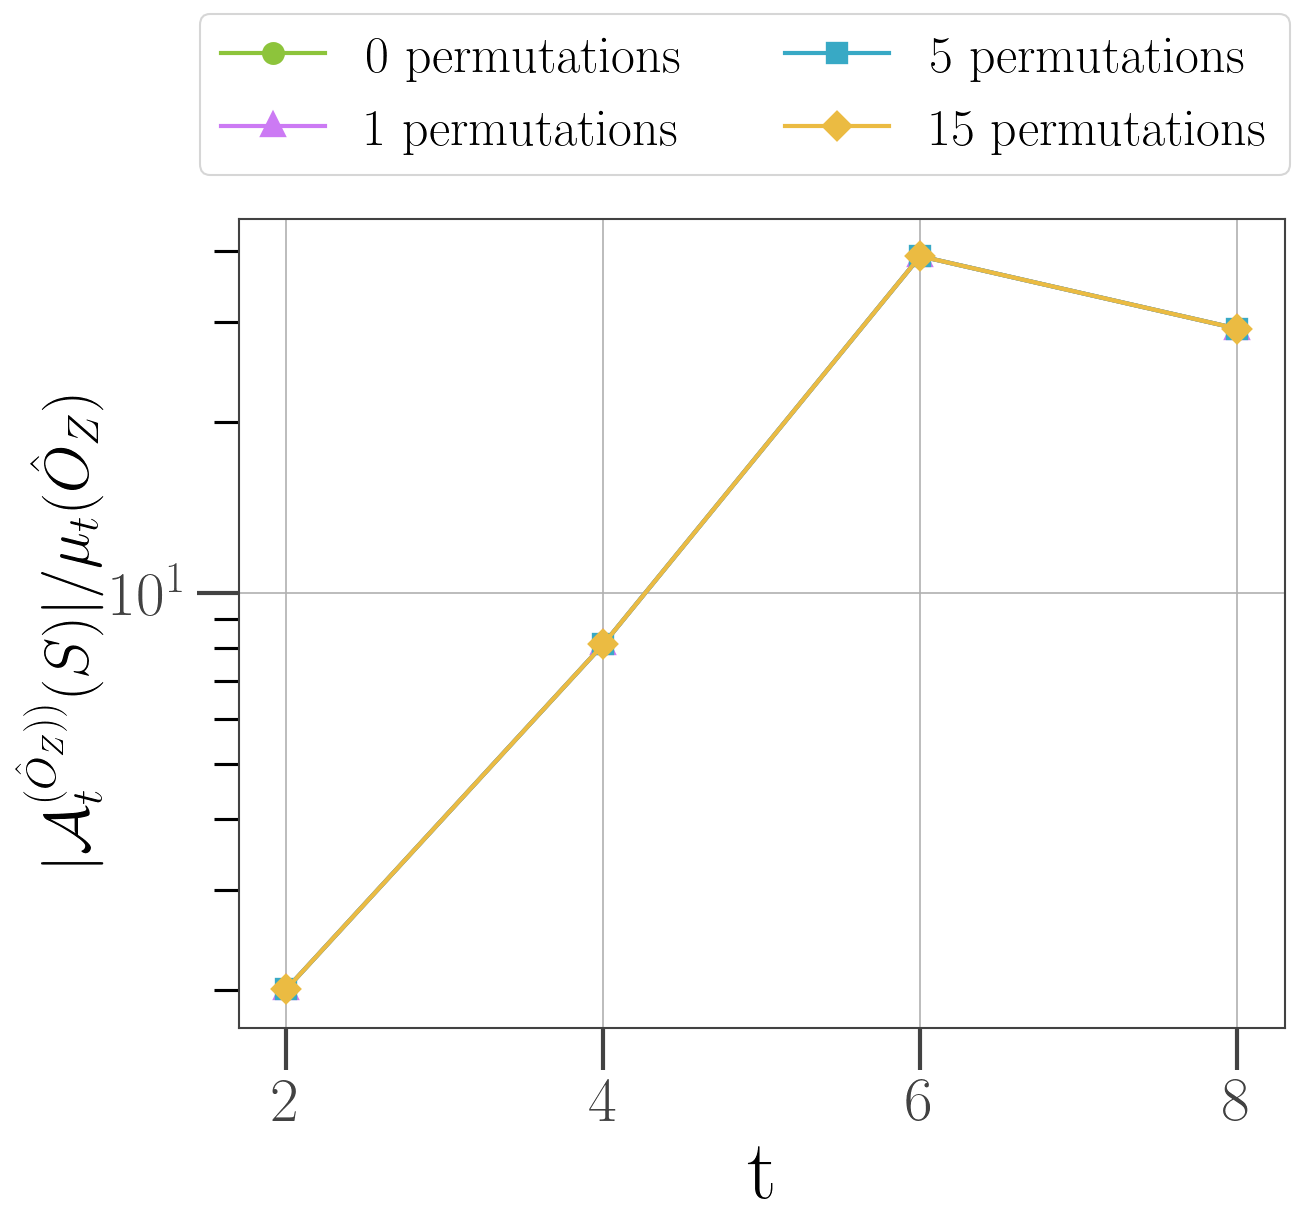

In [9]:
grey = '#424242'
cols = sns.color_palette("husl", 5)[2:]
clrs = sns.color_palette("husl", 5)
clrs =  ['#8DC43B',cols[-1],  cols[-2], '#EBBB42']
ls = ['-', '--', ':','-.']
marker = ['o', '^', 's', 'D']
rcParams['figure.figsize'] = (9,7)
fig, ax = plt.subplots(nrows=1, ncols=1, sharex= True, sharey=True)
n_i = 8
permutations = [0,1,5,15]
samples = 10000
epsilon = 0.07
ts = [2,4,6,8]


for j,p in enumerate(permutations):
    if p == 0:
        sample_perm = 1
    else: 
        sample_perm = 2*n_i

    st_file = f'data/R_permutations/v2_std:{p}_nqubits:{n_i}_sample_permutations:{sample_perm}_sample:{samples}_epsilon:{epsilon}.npz'
    loaded_array = np.load(permutation_file)
    r_p = loaded_array[loaded_array.files[0]]
    loaded_array = np.load(st_file)
    error = loaded_array[loaded_array.files[0]]

    
    ax.plot(ts,r_p,label = f'${str(p)}$ permutations', c = clrs[j], marker = marker[j], markersize = 7)
    ax.fill_between(ts, r_p-error, r_p+error, alpha = 0.2, facecolor = clrs[j])
    ax.set_yscale('log')
    ax.set_xticks([2,4,6,8])
    ax.set_ylabel(r'$|\mathcal{A}_t^{(\hat{O}_Z))} (S)|/ \mu_t (\hat{O}_Z) $ ', fontsize = 30)
    ax.set_xlabel('t')
ax.grid()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize = 25, bbox_to_anchor=(0.5,1.1))

ax.tick_params(color=grey, labelcolor=grey)
for spines in ax.spines.values(): 
    spines.set_edgecolor(grey)

plt.savefig('figs/simulation_conterexample_v2.pdf', bbox_inches='tight')
       


    
